In [94]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import time
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [95]:
music_rat_df = pd.read_json("data/Digital_Music_5.json", lines = True)
#meta_df = pd.read_json("meta_Digital_Music.json", lines = True)

In [96]:
music_rat_df = music_rat_df[['asin', 'overall', 'reviewText', 'reviewerID', 'reviewerName', 'summary']]
music_rat_df.rename(columns = {'asin':'artist_id', 'overall':'rating', 'reviewerID':'reviewer_id', 'reviewerName':'reviewer_name', 'reviewText':'review_text'}, inplace = True)

In [97]:
music_rat_df.head()

,artist_id,rating,review_text,reviewer_id,reviewer_name,summary
0,5555991584,5,"It's hard to believe ""Memory of Trees"" came ou...",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album
1,5555991584,5,"A clasically-styled and introverted album, Mem...",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant
2,5555991584,5,I never thought Enya would reach the sublime h...,A38IRL0X2T4DPF,bob turnley,The best so far
3,5555991584,5,This is the third review of an irish album I w...,A22IK3I6U76GX0,Calle,Ireland produces good music.
4,5555991584,4,"Enya, despite being a successful recording art...",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to


# Train Test Split

In [98]:
#Train test split
n_unique_users = music_rat_df['reviewer_id'].nunique()
n_unique_items = music_rat_df['artist_id'].nunique()

train_data, test_data = train_test_split(music_rat_df, test_size=0.25)

In [99]:
users_dictionary = {}
items_dictionary = {}
ci = 0 
cu = 0

for i in range(0, music_rat_df.shape[0]-1):
    if (items_dictionary.get(music_rat_df.iloc[i].artist_id) == None):
        items_dictionary.update({ music_rat_df.iloc[i].artist_id : ci})
        ci+=1
        
    if (users_dictionary.get(music_rat_df.iloc[i].reviewer_id) == None):
        users_dictionary.update({music_rat_df.iloc[i].reviewer_id : cu})
        cu+=1

In [100]:
item_val_array = np.fromiter(iter(items_dictionary.values()), dtype=int)
item_val_array = np.sort(item_val_array)

user_val_array = np.fromiter(iter(users_dictionary.values()), dtype = int)
user_val_array = np.sort(user_val_array)

In [101]:
user_val_array

array([   0,    1,    2, ..., 5538, 5539, 5540])

In [102]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_unique_users, n_unique_items))
for line in train_data.itertuples():
    train_data_matrix[users_dictionary.get(line[4]), items_dictionary.get(line[1])] = line[2]
    
test_data_matrix = np.zeros((n_unique_users, n_unique_items))
for line in test_data.itertuples():
    test_data_matrix[users_dictionary.get(line[4]), items_dictionary.get(line[1])] = line[2]

In [103]:
train_data_matrix.shape

(5541, 3568)

In [104]:
train_data_matrix

array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [105]:
np.count_nonzero(train_data_matrix)

48529

In [106]:
np.count_nonzero(test_data_matrix)

16177

# Memory-Based Collaborative Filtering

- <h4> First calculate similarity between users </h4>
<p> For that purpose, we will use the following formula: 
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

In [107]:
user_similarity = pairwise_distances(train_data_matrix, metric = 'cosine')

 - <h4> Then calculate similarity between artists </h4>
 <p> For that purpose, similar formula will be used:</p>
 
 <img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

In [108]:
item_similarity = pairwise_distances(train_data_matrix.T, metric = 'cosine')

- Next step is to make predictions. We have already created similarity matrices: `user_similarity` and `item_similarity` and therefore we can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

We can look at the similarity between users k and a as weights that are multiplied by the ratings of a similar user a (corrected for the average rating of that user). We will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict.


- 
When making a prediction for item-based CF we don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [116]:
def predict(ratings, similarity, type = 'user'):
    if type == 'user':
        mean_user_rating = np.nanmean(ratings, axis = 1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis = 1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])
    return pred

In [117]:
user_prediction = predict(train_data_matrix, user_similarity, type = 'user')
item_prediction = predict(train_data_matrix, item_similarity, type = 'item')

In [118]:
user_prediction

array([[ 0.0680513 ,  0.06215174,  0.0842585 , ...,  0.05707474,
         0.06122573,  0.05587934],
       [ 0.01971732,  0.0145009 ,  0.03665974, ...,  0.00942759,
         0.01357422,  0.00833684],
       [ 0.01263669,  0.00807403,  0.02990381, ...,  0.002931  ,
         0.0070997 ,  0.00189121],
       ...,
       [ 0.01100292,  0.00323371,  0.02545725, ..., -0.00182531,
         0.00233032, -0.0031254 ],
       [ 0.01325236,  0.00547946,  0.02771358, ...,  0.00041803,
         0.00457563, -0.00086301],
       [ 0.01099879,  0.0032321 ,  0.02544843, ..., -0.00182527,
         0.002329  , -0.00315654]])

- <h4> Evaluate model performance using RMSE : </h4>
<img src="https://latex.codecogs.com/gif.latex?MSE&space;=\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

In [133]:
def mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [134]:
print('User-based CF MSE: ' + str(mse(user_prediction, test_data_matrix)))
print('Item-based CF MSE: ' + str(mse(item_prediction, test_data_matrix)))

User-based CF MSE: 18.65514175419981
Item-based CF MSE: 18.770175389057083


# Top-k Collaborative Filtering

In [120]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [126]:
fast_prediction = predict_fast_simple(train_data_matrix, user_similarity, kind='user')
print('User-based CF MSE: ' + str(get_mse(fast_prediction, test_data_matrix)))


User-based CF MSE: 18.84233423489277


In [129]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [132]:
slow_topK = predict_topk(train_data_matrix, user_similarity, kind='user', k = 10)
print('User-based CF MSE: ' + str(get_mse(slow_topK, test_data_matrix)))

User-based CF MSE: 18.92663040118687


In [53]:
mean = train_data_matrix.mean(axis=1)[np.argsort(user_similarity[:,0])[:-15-1:-1]]

In [54]:
train_data_matrix[:,0][np.argsort(user_similarity[:,0])[:-15-1:-1]] - mean

array([-0.00560538, -0.00616592, -0.01205157, -0.00504484, -0.00532511,
       -0.00420404, -0.01569507, -0.01036996, -0.00392377, -0.0081278 ,
       -0.00560538, -0.00756726, -0.00476457, -0.00560538, -0.00588565])

In [66]:
train_data_matrix[0].mean()

0.06390134529147982

In [ ]:
pred = predict_topk(train_data_matrix, user_similarity, kind='user', k=15)
print ('Top-k User-based CF MSE: ' + str(rmse(pred, test_data_matrix)))

- <b>Check performance of the model by using given predictions for rating to get information about artists that the given user would like</b>

In [76]:
def get_top_artist_ids(artists_dictionary, values):
    ids = []
    
    for i in range(0, len(values-1)):
        ids.append(list(artists_dictionary.keys())[list(artists_dictionary.values()).index(values[i])])
    
    return ids

In [19]:
def get_artists_description(artist_ids, music_df):
    descriptions = []
    
    for i in range(0, len(artist_ids) - 1):
        res_df = music_df.query("artist_id == '" + artist_ids[i] + "'")
        descriptions.append(res_df['summary'].tolist())
    return descriptions

In [56]:
np.argsort(user_prediction[3])[::-1]

array([2144, 2050, 1777, ..., 2849,   40, 3247], dtype=int64)

In [67]:
np.count_nonzero(train_data_matrix[3])

6

In [64]:
ids = get_top_artist_ids(items_dictionary, np.argsort(user_prediction[3])[::-1][:10])

In [65]:
get_artists_description(ids,music_rat_df)

[['Very OVERRATED',
  "50 Cent's Best Work To Date",
  'In the land of the deaf, the man with one ear is king',
  '50 Somehow Lives Up To the Hype',
  'get rich or die trying',
  '50 Cent makes his debut',
  "Well, I'm really not sure where to start here",
  'Fifty is on fire',
  'Get Rich, Get rich my ass.',
  '5O CENT ON TOP',
  'u hating mothasuckas make me laugh',
  '50 Cents Get Rich Or Die Trying is 4.5 star CD',
  'great',
  'In Da Club is where I belong.',
  '50 is sooo sick with it',
  'WOW',
  'G UNIT',
  '"If I can\'t do it, it can\'t be done"',
  'Quality Debut!',
  'A Lil Bit Overhyped...but still packs the "Heat"...',
  '50 Cent is a ..."Rap Star"',
  'Mike Jones????..... No Whoo Kid',
  'a mental handicapped man can rap better',
  'NOT BAD',
  'check these out instead',
  'The Worst Music At Its Worst!!!',
  'Gangsta gold',
  'I do not get the hype',
  '50 Cent gets my two cents...',
  "rap's copy cat",
  'Kelvin Martin Is Spinning In His Grave',
  '50 and Eminem -- the 

In [90]:
ids_items = get_top_artist_ids(items_dictionary, np.argsort(item_prediction[3])[::-1][:10])

In [91]:
get_artists_description(ids_items, music_rat_df)

[["Follow Up To 'Life'",
  "cut the filler and you've got 5 stars.",
  'Skip a few, love the rest',
  'Very Soulful',
  'Good Work',
  'a final album of cover versions and his last of the 1960s'],
 ['Something You Can Groove AND Listen To',
  'For Those Who REALLY Like To Groove!',
  'Turn up the Raydio!',
  'A solid Album...........',
  'NEED THIS ONE FOR TO COMPLETE MY MUSIC LIBRARY',
  'Bumping Set'],
 ['Unbelieveable greatest from the FIRST goddess of disco!',
  'What a Voice',
  'A Great VOice',
  'Rootsy soul and soulful disco',
  "The unsung princess of  1970's Disco and R&amp;B"],
 ['excellent and a hlaf',
  'Great Music',
  '...man, i cant complain...',
  'A mixed bag of Grant and Donald  treats 3.5 stars',
  'Pretty Forgettable session'],
 ['4 1/2 stars.',
  'the best of both worlds?',
  'Historical document; enjoyable but not essential',
  'Half cooked',
  "Feelin' The Vibe",
  'Not real Coltrane.',
  'Important experiment; mixed results'],
 ['Pretty good collection',
  'KEI

# Model-Based Collaborative filtering
  - <b>SVD</b> (Singular Value Decomposition)
  
A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations, for more information I recommend to read articles: [Netflix Recommendations: Beyond the 5 stars](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html) and [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).
The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

In [21]:
#adjusting parameter K for SVD
error_rate = []

# Will take some time
for i in range(1,50):  
    u, s, vt = svds(train_data_matrix, k = i)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    error_rate.append(rmse(X_pred, test_data_matrix))

In [22]:
for i in range(50,70):  
    u, s, vt = svds(train_data_matrix, k = i)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    error_rate.append(rmse(X_pred, test_data_matrix))

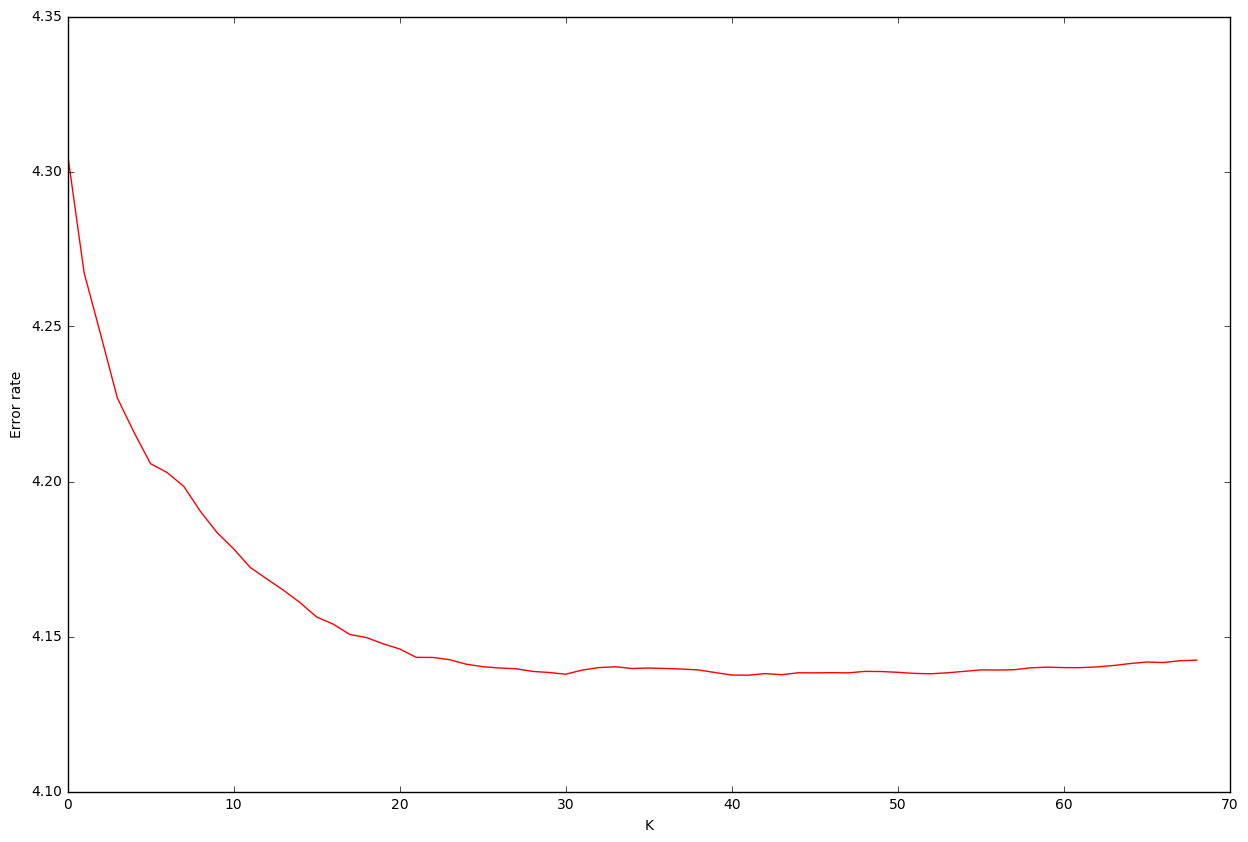

In [23]:
plt.figure(figsize=(15,10))
plt.xlabel("K")
plt.ylabel("Error rate")
plt.plot(error_rate, "r")
plt.show()

In [24]:
np.argmin(np.array(error_rate))

41

In [25]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 46)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 4.138271470384035


In [70]:
np.count_nonzero(X_pred[3])

3568

In [73]:
ids = get_top_artist_ids(items_dictionary, np.argsort(X_pred[3])[::-1][:15])

In [74]:
get_artists_description(ids,music_rat_df)

[['Excellent Debut, Though Not My Favorite Tori Project',
  'this debut is a classic',
  'WONDERFUL',
  'A Piano that Rocks',
  '"Poison me against the moon..."',
  'What could be said?',
  'Big Earthquakes',
  'One of the best Albums-must own',
  'Little Earthquakes',
  'Great Songwriter...',
  'Pure Catharsis Like A Sonic Greek Tragedy Without The Incest',
  'Phenomenal.',
  'Tori bares her heart and soul..',
  'Little Earthquakes',
  "On of the best album's of the 90's",
  'Definitely a five-star piece of work.',
  'Happy Phantoms',
  'tori iffic!!',
  'I think some stars need to shine with this light',
  'One Of The Best Debut Albums In History',
  'A 5.0',
  "Lemme tell you somethin':",
  'Perfect From Start To Finish',
  "Tori's Beginnings",
  'Self - Portrait',
  "Her best album, and that's saying rather a lot.",
  'tori amos is refreshing',
  'Honest, powerful, beautiful, and meaningful',
  'The best songs are stunning',
  'Pseudointellectual Farce or Brilliant Introspection',


In [86]:
array_1 = train_data_matrix[3][train_data_matrix[3].nonzero()]
array_1

array([5., 5., 4., 3., 5., 4.])

In [87]:
ids_original = get_top_artist_ids(items_dictionary, np.argsort(train_data_matrix[3][train_data_matrix[3].nonzero()])[::-1])

In [88]:
get_artists_description(ids_original,music_rat_df)

[['(4.5 STARS) COOL MEETS BOSSA NOVA',
  'Good precursor to Getz/Gilberto',
  'The soundtrack to my dreams.',
  'The Start of the Jazz Samba Movement',
  'irresistable and magical',
  'Jazz Samba is a great recording..but the first bossa record?',
  'Essential Jazz Album for Your Music Library!',
  'Beautiful &amp; breezy',
  'Gorgeously tired',
  'Perfection',
  'Swirling, beautiful bossa nova-jazz',
  'Bossa nova music that dips, swings, boasts fine harmonic structures--and an infectious rhythmic pulse !!!',
  'Ground Zero',
  'Bossa Nova Baby',
  'WONDERFUL',
  'Every Bit As Worth As Getz/Gilberto',
  'Stan and Charlie record first Bossa Nova hit.',
  'The Duet Masterpiece That Made Music History!',
  'A beautiful introduction to Samba music',
  'Essential Music'],
 ["Changing the R&B Face in '94",
  'Solid sounds,from two sexy soulful sistas',
  'How To Be Blown Away',
  'VERY LIGHT VOICES BUT GOOD!!!!',
  'changing faces cd',
  'A Good album',
  'ONE OF THE BEST IF NOT BEST R&amp;